In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from cluster_local_new import ClusterLensing_fyp
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import corner

In [2]:
# inject data

scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data 
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)


# Example: Access the first datax array
print(f"Length of the first datax array: {len(datax_list[4])}")


Length of the first datax array: 878


In [3]:
# getting the pixel scale list
def get_pixscale(cluster_name, file_path='GCdata/pixsize'):
    full_path = os.path.join(file_dir, file_path)
    with open(full_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(cluster_name):
                # Split the line to get the value after the colon and return it as a float
                return float(line.split(':')[1].strip())
    return None  # Return None if the cluster name isn't found

pixscale_list = []
for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]
    pixscale = get_pixscale(full_cluster_name)
    pixscale_list.append(pixscale)
print(pixscale_list)


[0.2, 0.25, 0.25, 0.2, 0.2, 0.2]


In [4]:
# set up the class
cluster = ClusterLensing_fyp(datax_list, datay_list, data_psi_list, 0.5, 1, pixscale_list, diff_z=False)


/home/dices/.venv/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


In [5]:
# check with the lenstronomy package directly
realsize = 678
grid = np.linspace(0, realsize-1, realsize)
grid = grid * 0.25

lens_model_list2 = ['INTERPOL']
kwargs_lens2 = [{'grid_interp_x': grid, 'grid_interp_y': grid, 'f_': data_psi_list[1]*0.25**2,
                          'f_x': datax_list[1], 'f_y': datay_list[1]}]
lensModel_real = LensModel(lens_model_list=lens_model_list2, z_source=1, z_lens=0.5)

# Use lens equation solver for verification
solver2 = LensEquationSolver(lensModel_real)
coord = (63.8, 84.1)
img_po = solver2.image_position_from_source(coord[0], coord[1], kwargs_lens2, min_distance=0.25, search_window=100, verbose=False, x_center=75, y_center=80)
print(img_po)

arrival_time = lensModel_real.arrival_time(img_po[0], img_po[1], kwargs_lens2)
arrival_time = arrival_time - arrival_time.min()
print(arrival_time)


(array([25.04527574, 80.3895084 , 89.83823507, 70.3500693 , 62.87531747,
       63.56479705, 78.41485862]), array([96.30394225, 51.47812429, 71.45908221, 59.92729871, 45.81923451,
       52.27263524, 72.34180586]))
[    0.         88594.90558077 91797.85200698 91896.81383927
 92121.65322825 92551.52745512 93534.55033072]


In [ ]:
# mixed mcmc and DE
parameters = [80.5,74.0,3.2,0] # x, y, z, index
dt_obs = cluster.image_and_delay_for_xyz(parameters[0], parameters[1], parameters[2], parameters[3])[2]
print("True time delays:", dt_obs)

de_solution, mcmc_solution, sampler, samples = cluster.localize_diffevo_then_mcmc_known_cluster(
    dt_true=dt_obs,
    index=parameters[3],
    # DE settings
    early_stop=5e4,
    # MCMC settings
    n_walkers=21, n_steps=1500, burn_in=800,
                               x_range_prior=10.0, y_range_prior=10.0,
                               z_lower=2, z_upper=3.5,
                               sigma=0.05,
                               n_processes=12
)

print("DE solution:", de_solution)
print("MCMC median:", mcmc_solution)
#print("samples shape:", samples.shape)

D_S: 1557.383 Mpc
D_LS: 1208.773 Mpc
Candidate scale: 0.776
True time delays: [   0.         4722.09151606 5726.87137736 6178.592956   6376.37992613
 6552.76725006]


In [ ]:
index, xyz= 1, [67.5,81,3]

x_img, y_img, dt = cluster.my_image_and_delay_for_xyz(67.5,81,3.1, index=1)
print("Image positions =", x_img, y_img)
print("Time delays     =", dt)

In [ ]:
# de + mcmc with unknown cluster

parameters = [87.3,73.4,2.92, 0] # x, y, z, index
dt_obs = cluster.my_image_and_delay_for_xyz(parameters[0], parameters[1], parameters[2], parameters[3])[2]
print("True time delays:", dt_obs)

opt_index, opt_pos, opt_chi_sq, sampler, samples = cluster.localize_diffevo_then_mcmc(
    dt_true=dt_obs,
    # DE settings
    early_stop=5e4,
    # MCMC settings
    n_walkers=12, n_steps=2500, burn_in=1500,
                               x_range_prior=10.0, y_range_prior=10.0,
                               z_lower=2, z_upper=3.5,
                               sigma=0.05,
                               n_processes=24
)

print("Best fit parameters:", opt_pos)
print("Optimized Chi squared value:", opt_chi_sq)
print("samples shape:", samples.shape)

src = pd.read_csv('src_pos_for_dist_with_z_de+mcmc.csv')
src.at[i, 'indices'] = parameters[3]
src.at[i, 'x'] = parameters[0]
src.at[i, 'y'] = parameters[1]
src.at[i, 'z'] = parameters[2]
src.at[i, 'localized_index'] = opt_index
src.at[i, 'localized_x'] = opt_pos[0]
src.at[i, 'localized_y'] = opt_pos[1]
src.at[i, 'localized_z'] = opt_pos[2]
src.at[i, 'localized_chi_sq'] = opt_chi_sq
src.to_csv('src_pos_for_dist_with_z_de+mcmc.csv', index=False)

True time delays: [    0.           710.49914652 17146.05042892 17604.37369496
 18606.96196507 18742.00990936 19530.08562408]
differential_evolution step 1: f(x)= 2800000000000.0
differential_evolution step 2: f(x)= 8981274396.55272
differential_evolution step 3: f(x)= 8981274396.55272
differential_evolution step 4: f(x)= 8981274396.55272
differential_evolution step 5: f(x)= 8981274396.55272
differential_evolution step 6: f(x)= 8981274396.55272
differential_evolution step 7: f(x)= 5326371374.976579
differential_evolution step 8: f(x)= 5326371374.976579
differential_evolution step 9: f(x)= 5326371374.976579
differential_evolution step 10: f(x)= 5326371374.976579
differential_evolution step 11: f(x)= 2822538061.7572985
differential_evolution step 12: f(x)= 2822538061.7572985
differential_evolution step 13: f(x)= 2822538061.7572985
differential_evolution step 14: f(x)= 734411155.0260468
differential_evolution step 15: f(x)= 734411155.0260468
differential_evolution step 16: f(x)= 734411155

100%|██████████| 2500/2500 [1:30:47<00:00,  2.18s/it]

MCMC median after DE: x=87.30, y=73.40, z=2.92
Replaced original opt.


differential_evolution step 1: f(x)= 5600000000000.0
differential_evolution step 2: f(x)= 2800000000000.0
differential_evolution step 3: f(x)= 2800000000000.0
differential_evolution step 4: f(x)= 2800000000000.0
differential_evolution step 5: f(x)= 2800000000000.0
differential_evolution step 6: f(x)= 2800000000000.0
differential_evolution step 7: f(x)= 2800000000000.0
differential_evolution step 8: f(x)= 2800000000000.0
differential_evolution step 9: f(x)= 2800000000000.0
differential_evolution step 10: f(x)= 2800000000000.0
differential_evolution step 11: f(x)= 2800000000000.0
differential_evolution step 12: f(x)= 65937622991.92017
differential_evolution step 13: f(x)= 65937622991.92017
differential_evolution step 14: f(x)= 65937622991.92017
differential_evolution step 15: f(x)= 65937622991.92017
differential_evolution step 16: f(x)= 65937622991.92017
differential_evolution step 17: f(x)= 65937622991.92017
differential_evolution step 18: f(x)= 65937622991.92017
differential_evolution 

Process ForkPoolWorker-51:
Process ForkPoolWorker-57:
Process ForkPoolWorker-55:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-58:
Process ForkPoolWorker-53:
Process ForkPoolWorker-52:
Process ForkPoolWorker-50:
Process ForkPoolWorker-54:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*

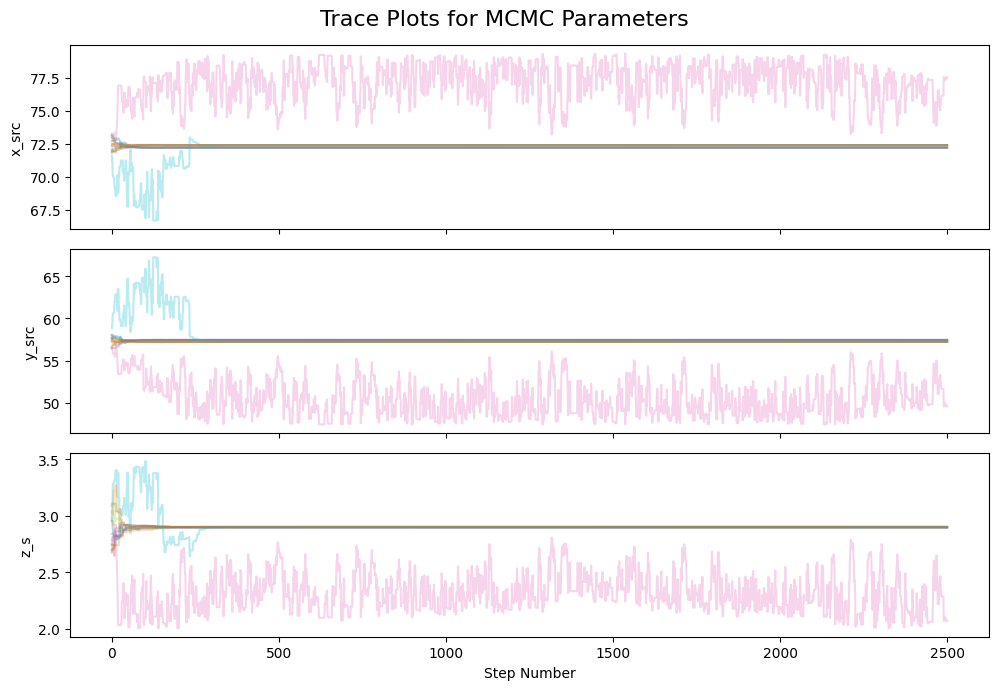

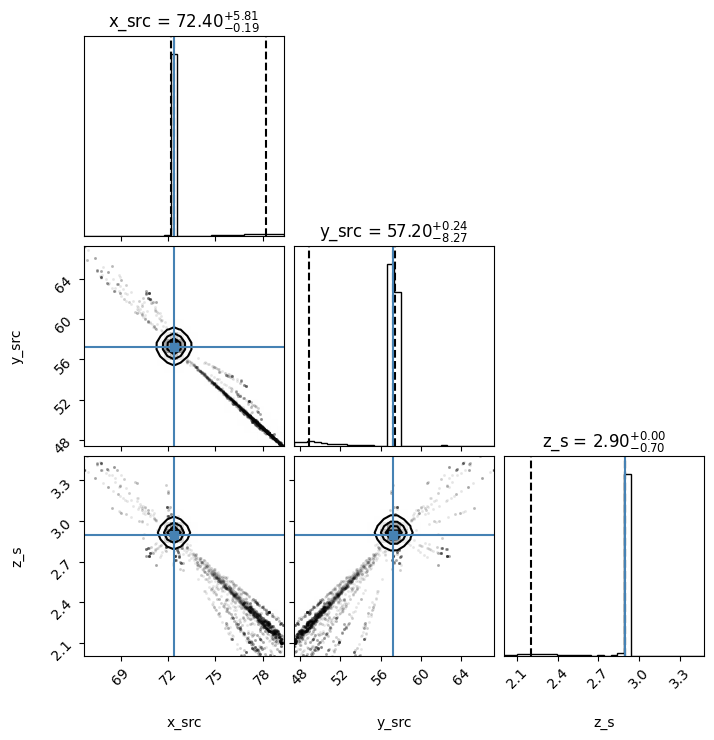

In [ ]:
# Assuming sampler is your emcee sampler object and burn_in is defined.
# Retrieve the chain; shape: (n_steps, n_walkers, ndim)
burn_in = 1500
chain = sampler.get_chain(flat=False)
log_probs = sampler.get_log_prob(discard=burn_in, flat=True)
n_steps, n_walkers, ndim = chain.shape
labels = ["x_src", "y_src", "z_s"]

# --- Plot Trace Plots ---
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    for walker in range(n_walkers):
        ax.plot(chain[:, walker, i], alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step Number")
plt.suptitle("Trace Plots for MCMC Parameters", fontsize=16)
plt.tight_layout()
#plt.savefig('de_mcmc/de_mcmc_trace_fixz.pdf')
plt.show()

# --- Plot Corner Plot ---
# Flatten the chain (each walker’s chain concatenated) after burn-in.
flat_samples = sampler.get_chain(flat=True)

figure = corner.corner(
    flat_samples,
    labels=labels,
    quantiles=[0.025, 0.5, 0.975],  # 95% interval
    show_titles=True,
    truths=[parameters[0], parameters[1], parameters[2]],  # True values
    smooth=1.0,  # Smooth out contours
    bins=30,     # Increase the number of bins
)

#plt.savefig('de_mcmc/de_mcmc_corner_fixz.pdf')
plt.show()


In [9]:
print(np.mean(sampler.acceptance_fraction))

0.31173333333333336


In [10]:
samples = sampler.get_chain(discard=burn_in, flat=True)  # shape: (n_samples, n_dim)

# 2) Retrieve the corresponding log-prob values for each sample
log_probs = sampler.get_log_prob(discard=burn_in, flat=True)  # shape: (n_samples,)

# 3) Find the index of the maximum log-likelihood
best_idx = np.argmax(log_probs)

# 4) Extract the parameter set with the largest log-likelihood
best_params = samples[best_idx]
best_chi_sq = cluster.chi_squared_with_z(best_params, dt_obs, index=0)

print(f"Best-fitting parameters = {best_params}")
print(f"Optimized chi-squared   = {best_chi_sq}")

Best-fitting parameters = [72.39999872 57.19999893  2.90000141]
Optimized chi-squared   = 5600000000000.0


In [11]:
tau = sampler.get_autocorr_time()
print("Autocorr times:", tau)

Autocorr times: [34.23078406 37.9474813  34.67504867]


In [14]:

#print(dt_obs)
print(cluster.my_image_and_delay_for_xyz(80.1,99.9,3.3,4)[2])
#chisq = cluster.chi_squared_with_z([70.01320813, 75.02377333,  3.11390395], dt_obs, index=1)
#print("Chi squared value:", chisq)

[    0.         63511.36869834 74572.75260626 74999.14298262
 80795.70605133]
